# Two-Qubit Gates

> 5/31/19

This document explores the noise/error characteristics for two-qubit gates on the IBM quantum devices. I'll just start off by importing some snippets I usually like to have:

In [2]:
# import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.ignis.verification.randomized_benchmarking as rb
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

In [8]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
#   **kwargs: additional keyword args to pass to qiskit.execute
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5,
        backend=None, opt=True, **kwargs):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager,
                    **kwargs)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [4]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

Next, we identify the currently least-busy IBM backend on which we can run our tests. This doesn't really matter that much (and the least-busy backend right now probably won't be in the future), but we'd like to perform all of our tests on the same device if possible.

In [29]:
available = q.IBMQ.backends(filters=lambda x:
                            x.configuration().n_qubits >= 5
                            and not
                            x.configuration().simulator)
backend = q.providers.ibmq.least_busy(available)

print('The best backend is %s' % backend.name())

The best backend is ibmqx4


We'll use the Qiskit Ignis verification framework to run some randomized benchmarking tests. The decay constant for these tests should give us some measure of the two-qubit gate noise, although the exact physical meaning of this constant is unclear (see [Proctor et al.](https://arxiv.org/pdf/1702.01853.pdf)).

In [58]:
# Ignis randomized benchmarking parameters
nseeds = 5
length_vector = np.arange(1, 100, 5)
rb_pattern = [[0, 2]]  # two-qubit benchmarking between Q0 and Q2

In [59]:
# generate and run the circuits
rb_circs, xdata = rb.randomized_benchmarking_seq(nseeds, length_vector, rb_pattern)
backend = q.IBMQ.get_backend('ibmqx4')  # keep backend consistent for later runs
jobs = []
for seed, circ in enumerate(rb_circs):
    job, backend, _ = run(circ, backend=backend)
    jobs += [job]

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf180e901c24500754b9763'
Ran on backend 'ibmqx4'
Completed 2019-05-31T19:30:49.153Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf1817a8a1a3d0071e7b490'
Ran on backend 'ibmqx4'
Completed 2019-05-31T19:33:14.299Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf1820b20eddf006c8e4caf'
Ran on backend 'ibmqx4'
Completed 2019-05-31T19:35:39.373Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf182988a1a3d0071e7b493'
Ran on backend 'ibmqx4'
Completed 2019-05-31T19:37:59.865Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf18326f5e9cd006d59cc80'
Ran on backend 'ibmqx4'
Completed 2019-05-31T19:40:22.676Z


Next, for each gate length, we'll get the average ground state population as well as the standard error. We will then fit these data to an exponential model and find the decay constant with Scipy.

In [65]:
# collect all the run data into parallel lists
job_ids = ['5cf180e901c24500754b9763',
           '5cf1817a8a1a3d0071e7b490',
           '5cf1820b20eddf006c8e4caf',
           '5cf182988a1a3d0071e7b493',
           '5cf18326f5e9cd006d59cc80']
data = []
for i, jid in enumerate(job_ids):
    # find frequency of ground state (00)
    data += [[]]
    job = get_job(jid, 'ibmqx4')
    for j, _ in enumerate(length_vector):
        counts = Counter(job.result().get_counts(j))
        data[i] += [(counts['000'] + counts['010']) / 1024.]

# get avg and stderr for each gate series length
avg = list(map(np.average, zip(*data)))
stderr = list(map(np.std, zip(*data)))

Text(0.5, 1.0, 'IBM Tenerife Randomized Benchmarking (Q$_0$ and Q$_2$)')

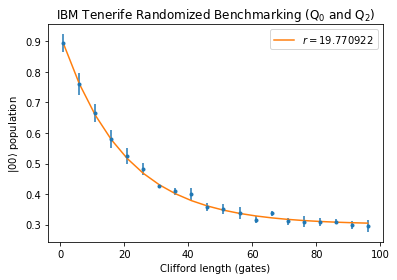

In [68]:
from scipy.optimize import curve_fit

# pure exponential decay model
def exp_decay(x, a, b, c):
    return a * np.exp(-x / b) + c

# fit curve using scipy
# since we do not use length multipliers,
#   the x-series is the length vector
params = curve_fit(exp_decay, length_vector, avg,
                   p0=[0.5, 10, 0.5], sigma=stderr)[0]

# plot everything prettily
fig, ax = plt.subplots()
ax.errorbar(length_vector, avg, stderr,
            linestyle='None', marker='.')
ax.plot(length_vector, exp_decay(length_vector, *params),
        label='$r = %f$' % params[1])
ax.legend()
ax.set_xlabel('Clifford length (gates)')
ax.set_ylabel(r'$\vert 00 \rangle$ population')
ax.set_title('IBM Tenerife Randomized Benchmarking (Q$_0$ and Q$_2$)')

For comparison, here are the results for the same test against Q<sub>0</sub> and Q<sub>1</sub> on the Tenerife:

![Q0/Q1 randomized benchmarking](img/rb_0_1.png)

In the interest of later reproducibility, the job IDs for that experiment were `['5cf1756a7b248a00732994a0', '5cf177293bad81007b05390d', '5cf178de8a1a3d0071e7b461', '5cf17adde6d6dc0074ed611c', '5cf17d4aa95119007977fb74']`, and the length vector was `np.arange(0, 100, 10)`. Likewise, randomized becnhmarking for Q<sub>1</sub> and Q<sub>2</sub> was done with job IDs `['5cf18e3820eddf006c8e4cd0', '5cf18f016a1bf200771683af', '5cf19094e6d6dc0074ed6175', '5cf19244f5e9cd006d59ccc0', '5cf193e601c24500754b979e']`; the plot is below:

![Q1/Q2 randomized benchmarking](img/rb_1_2.png)

Now we can run the same experiment for other qubits. Since the procedure for this is basically just the procedure applied above (which I think is reasonably well-documented), I will dispense with most of the narrative accompanying the code.

In [73]:
# Ignis randomized benchmarking
nseeds = 5
length_vector = np.arange(1, 100, 10)
backend = q.IBMQ.get_backend('ibmqx4')

meta_jobs = []
for pattern in [[[2, 3]], [[3, 4]], [[2, 4]]]:
    print('Running experiment for Q%d and Q%d' % tuple(pattern[0]))
    rb_circs, xdata = rb.randomized_benchmarking_seq(nseeds, length_vector, pattern)
    jobs = []
    for seed, circ in enumerate(rb_circs):
        job, backend, _ = run(circ, backend=backend)
        jobs += [job]
    meta_jobs += [jobs]
    
    data = []
    for i, job in enumerate(jobs):
        data += [[]]
        for j, _ in enumerate(length_vector):
            counts = job.result().get_counts(j).items()
            tmp = filter(lambda x: x[0][pattern[0][0]] == '0' and x[0][pattern[0][1]] == '0', counts)
            freq = sum(map(lambda x: x[1], tmp)) / 1024.
            data[i] += [freq]
            
    avg = list(map(np.average, zip(*data)))
    stderr = list(map(np.std, zip(*data)))

    params = curve_fit(exp_decay, length_vector, avg,
                       p0=[0.5, 10, 0.5], sigma=stderr)[0]
    xs = np.linspace(0, max(length_vector), 100)  # continuous domain for plotting

    fig, ax = plt.subplots()
    ax.errorbar(length_vector, avg, stderr,
                linestyle='None', marker='.')
    ax.plot(xs, exp_decay(xs, *params),
            label='$r = %f$' % params[1])
    ax.legend()
    ax.set_xlabel('Clifford length (gates)')
    ax.set_ylabel(r'$\vert 00 \rangle$ population')
    ax.set_title('IBM Tenerife Randomized Benchmarking (Q$_%d$ and Q$_%d$)' % tuple(pattern[0]))

Running experiment for Q1 and Q2


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf18e3820eddf006c8e4cd0'
Ran on backend 'ibmqx4'
Completed 2019-05-31T20:27:36.792Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf18f016a1bf200771683af'
Ran on backend 'ibmqx4'
Completed 2019-05-31T20:30:56.430Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf19094e6d6dc0074ed6175'
Ran on backend 'ibmqx4'
Completed 2019-05-31T20:37:40.442Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf19244f5e9cd006d59ccc0'
Ran on backend 'ibmqx4'
Completed 2019-05-31T20:44:51.407Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cf193e601c24500754b979e'
Ran on backend 'ibmqx4'
Completed 2019-05-31T20:51:50.217Z
Running experiment for Q2 and Q3


KeyboardInterrupt: 

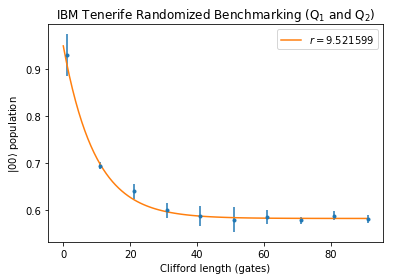

In [76]:
for _ in [None]:
    rb_circs, xdata = rb.randomized_benchmarking_seq(nseeds, length_vector, pattern)    
    job_ids = ['5cf18e3820eddf006c8e4cd0',
               '5cf18f016a1bf200771683af',
               '5cf19094e6d6dc0074ed6175',
               '5cf19244f5e9cd006d59ccc0',
               '5cf193e601c24500754b979e']
    jobs = map(lambda x: get_job(x, 'ibmqx4'), job_ids)
    
    data = []
    for i, job in enumerate(jobs):
        data += [[]]
        for j, _ in enumerate(length_vector):
            counts = job.result().get_counts(j).items()
            tmp = filter(lambda x: x[0][1] == '0' and x[0][2] == '0', counts)
            freq = sum(map(lambda x: x[1], tmp)) / 1024.
            data[i] += [freq]

    avg = list(map(np.average, zip(*data)))
    stderr = list(map(np.std, zip(*data)))

    params = curve_fit(exp_decay, length_vector, avg,
                       p0=[0.5, 10, 0.5], sigma=stderr)[0]
    xs = np.linspace(0, max(length_vector), 100)  # continuous domain for plotting

    fig, ax = plt.subplots()
    ax.errorbar(length_vector, avg, stderr,
                linestyle='None', marker='.')
    ax.plot(xs, exp_decay(xs, *params),
            label='$r = %f$' % params[1])
    ax.legend()
    ax.set_xlabel('Clifford length (gates)')
    ax.set_ylabel(r'$\vert 00 \rangle$ population')
    ax.set_title('IBM Tenerife Randomized Benchmarking (Q$_1$ and Q$_2$)')